# Automatic data downloading

* In this example we will show how one can download data from a jupyter notebook.
* The [PhysOcean](https://github.com/gher-ulg/PhysOcean.jl) module provides ways to automatically download data from the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html) and from [CMEMS](http://marine.copernicus.eu/) In-Situ TAC.

This module can be installed by: 

```julia
using Pkg
Pkg.add("PhysOcean")
```


In [50]:
using PyPlot              # Visualization package
using PhysOcean           # Download data from the World Ocean Database
using DIVAnd              # DIVAnd 
using Dates
using Statistics

## Settings
Define the time and geospatial bounding box for downloading the data

In [51]:
# resolution (the resolution is only used for DIVAnd analyses)
dx = dy = 0.25   # medium size test 

# vectors defining the longitude and latitudes grids
# Here longitude and latitude correspond to the Mediterranean Sea
lonr = -7:dx:37
latr = 30:dy:46

# time range of the in-situ data
timerange = [Date(2016,1,1),Date(2016,12,31)]

2-element Array{Date,1}:
 2016-01-01
 2016-12-31

In [52]:
# Name of the variable
varname = "Salinity"

"Salinity"

Please use your own email address (!) 😉     
It is only use to get notified by mail once the dataset is ready.

In [53]:
if isfile("email.txt")
    email = strip(read("email.txt",String));
    print("getting email address from email.txt");
end


# Email for downloading the data
# Indicate here your email address
# email = "___@____.__"



getting email address from email.txt

## Download the data

* World Ocean Database: example for bulk access data by simulating a web-user.
* Downloading can take several tens of minutes.
* SeaDataNet will provide a dedicated machine-to-machine interface during the SeaDataCloud project

In [54]:
?WorldOceanDatabase.download

```
dirnames,indexnames = WorldOceanDatabase.download(lonrange,latrange,timerange,
  variable,email,basedir)
```

Download data using the NODC web-service. The range parameters are vectors from with the frist element is the lower bound and the last element is the upper bound. The parameters of the functions will be transmitted to nodc.noaa.gov (http://www.noaa.gov/privacy.html). Note that no XBT corrections are applied. The table below show the avialable variable and their units.

Example:

dirnames,indexnames = WorldOceanDatabase.download([0,10],[30,40],     [DateTime(2000,1,1),DateTime(2000,2,1)],     "Temperature","your@email.com,"/tmp")

| Variables                          | Unit     |
|:---------------------------------- |:-------- |
| Temperature                        | °C       |
| Salinity                           | unitless |
| Oxygen                             | ml l⁻¹   |
| Phosphate                          | µM       |
| Silicate                           | µM       |
| Nitrate and Nitrate+Nitrite        | µM       |
| pH                                 | unitless |
| Chlorophyll                        | µg l⁻¹   |
| Plankton                           | multiple |
| Alkalinity                         | meq l⁻¹  |
| Partial Pressure of Carbon Dioxide | µatm     |
| Dissolved Inorganic Carbon         | mM       |
| Transmissivity                     | m⁻¹      |
| Pressure                           | dbar     |
| Air temperature                    | °C       |
| CO2 warming                        | °C       |
| CO2 atmosphere                     | ppm      |
| Air pressure                       | mbar     |
| Tritium                            | TU       |
| Helium                             | nM       |
| Delta Helium-3                     | %        |
| Delta Carbon-14                    | ᵒ/ᵒᵒ     |
| Delta Carbon-13                    | ᵒ/ᵒᵒ     |
| Argon                              | nM       |
| Neon                               | nM       |
| Chlorofluorocarbon 11 (CFC 11)     | pM       |
| Chlorofluorocarbon 12 (CFC 12)     | pM       |
| Chlorofluorocarbon 113 (CFC 113)   | pM       |
| Delta Oxygen-18                    | ᵒ/ᵒᵒ     |


Define the directory where the results will be saved. This directory must exists and must be empty.   
The command `mkpath` will create this path (including parent path).

In [91]:
basedir = "./data/WOD-temporary-dir"
#=
if isdir(basedir)
    rm(basedir,recursive=true)
end
mkpath(basedir)

WorldOceanDatabase.download(lonr,latr,timerange,varname,email,basedir);
=#

"./data/WOD-temporary-dir"

Downloadling from World Ocean Database can take some time, result from the previsou

In [56]:
run(pipeline(`curl https://dox.ulg.ac.be/index.php/s/8tRk0NAStr2P70j/download`,`tar -C data -xvzf -`))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

WOD-temporary-dir/
WOD-temporary-dir/PFL/
WOD-temporary-dir/PFL/wod_017424830O.nc
WOD-temporary-dir/PFL/wod_017867477O.nc
WOD-temporary-dir/PFL/wod_017868469O.nc
WOD-temporary-dir/PFL/wod_017708710O.nc
WOD-temporary-dir/PFL/wod_017705460O.nc
WOD-temporary-dir/PFL/wod_017416833O.nc
WOD-temporary-dir/PFL/wod_017709684O.nc
WOD-temporary-dir/PFL/wod_017893158O.nc
WOD-temporary-dir/PFL/wod_017866617O.nc
WOD-temporary-dir/PFL/wod_017782318O.nc
WOD-temporary-dir/PFL/wod_017403893O.nc
WOD-temporary-dir/PFL/wod_017430010O.nc
WOD-temporary-dir/PFL/wod_017754845O.nc
WOD-temporary-dir/PFL/wod_017752516O.nc
WOD-temporary-dir/PFL/wod_017769855O.nc
WOD-temporary-dir/PFL/wod_017775580O.nc
WOD-temporary-dir/PFL/wod_017758088O.nc
WOD-temporary-dir/PFL/wod_017870101O.nc
WOD-temporary-dir/PFL/wod_017881952O.nc
WOD-temporary-dir/PFL/wod_017775956O.nc
WOD-temporary-dir/PFL/wod_018667651O.nc
WOD-temporary-dir/PFL/wod_017870424O.nc
WOD-temporary-dir/PFL/wod_017888245O.nc
WOD-temporary-dir/PFL/wod_017699430O.n

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

WOD-temporary-dir/PFL/wod_017896453O.nc
WOD-temporary-dir/PFL/wod_017788405O.nc
WOD-temporary-dir/PFL/wod_017770737O.nc
WOD-temporary-dir/PFL/wod_017901285O.nc
WOD-temporary-dir/PFL/wod_017420392O.nc
WOD-temporary-dir/PFL/wod_017673603O.nc
WOD-temporary-dir/PFL/wod_017867233O.nc
WOD-temporary-dir/PFL/wod_017901383O.nc
WOD-temporary-dir/PFL/wod_017690041O.nc
WOD-temporary-dir/PFL/wod_017870262O.nc
WOD-temporary-dir/PFL/wod_017406579O.nc
WOD-temporary-dir/PFL/wod_017771861O.nc
WOD-temporary-dir/PFL/wod_017889741O.nc
WOD-temporary-dir/PFL/wod_017774817O.nc
WOD-temporary-dir/PFL/wod_017866330O.nc
WOD-temporary-dir/PFL/wod_017876750O.nc
WOD-temporary-dir/PFL/wod_017434219O.nc
WOD-temporary-dir/PFL/wod_017752557O.nc
WOD-temporary-dir/PFL/wod_017416057O.nc
WOD-temporary-dir/PFL/wod_017869136O.nc
WOD-temporary-dir/PFL/wod_017897382O.nc
WOD-temporary-dir/PFL/wod_017866339O.nc
WOD-temporary-dir/PFL/wod_017429518O.nc
WOD-temporary-dir/PFL/wod_017427017O.nc
WOD-temporary-dir/PFL/wod_017752025O.nc


WOD-temporary-dir/PFL/wod_017894823O.nc
WOD-temporary-dir/PFL/wod_017868221O.nc
WOD-temporary-dir/PFL/wod_017409279O.nc
WOD-temporary-dir/PFL/wod_017871208O.nc
WOD-temporary-dir/PFL/wod_017404338O.nc
WOD-temporary-dir/PFL/wod_017411363O.nc
WOD-temporary-dir/PFL/wod_017869205O.nc
WOD-temporary-dir/PFL/wod_017711635O.nc
WOD-temporary-dir/PFL/wod_017690459O.nc
WOD-temporary-dir/PFL/wod_017868742O.nc
WOD-temporary-dir/PFL/wod_017438765O.nc
WOD-temporary-dir/PFL/wod_017426132O.nc
WOD-temporary-dir/PFL/wod_017869783O.nc
WOD-temporary-dir/PFL/wod_017867605O.nc
WOD-temporary-dir/PFL/wod_017870924O.nc
WOD-temporary-dir/PFL/wod_017674797O.nc
WOD-temporary-dir/PFL/wod_017866437O.nc
WOD-temporary-dir/PFL/wod_017874463O.nc
WOD-temporary-dir/PFL/wod_017868816O.nc
WOD-temporary-dir/PFL/wod_017765611O.nc
WOD-temporary-dir/PFL/wod_017788601O.nc
WOD-temporary-dir/PFL/wod_017779876O.nc
WOD-temporary-dir/PFL/wod_017866354O.nc
WOD-temporary-dir/PFL/wod_017759096O.nc
WOD-temporary-dir/PFL/wod_017900754O.nc


WOD-temporary-dir/PFL/wod_017911347O.nc
WOD-temporary-dir/PFL/wod_017879895O.nc
WOD-temporary-dir/PFL/wod_017405628O.nc
WOD-temporary-dir/PFL/wod_017866453O.nc
WOD-temporary-dir/PFL/wod_017691052O.nc
WOD-temporary-dir/PFL/wod_017425498O.nc
WOD-temporary-dir/PFL/wod_017682898O.nc
WOD-temporary-dir/PFL/wod_017867734O.nc
WOD-temporary-dir/PFL/wod_017869375O.nc
WOD-temporary-dir/PFL/wod_017868137O.nc
WOD-temporary-dir/PFL/wod_017779902O.nc
WOD-temporary-dir/PFL/wod_017709750O.nc
WOD-temporary-dir/PFL/wod_017354976O.nc
WOD-temporary-dir/PFL/wod_017699277O.nc
WOD-temporary-dir/PFL/wod_017438994O.nc
WOD-temporary-dir/PFL/wod_017776102O.nc
WOD-temporary-dir/PFL/wod_017867273O.nc
WOD-temporary-dir/PFL/wod_017776842O.nc
WOD-temporary-dir/PFL/wod_017866255O.nc
WOD-temporary-dir/PFL/wod_017433255O.nc
WOD-temporary-dir/PFL/wod_017404560O.nc
WOD-temporary-dir/PFL/wod_017911989O.nc
WOD-temporary-dir/PFL/wod_017431628O.nc
WOD-temporary-dir/PFL/wod_017441178O.nc
WOD-temporary-dir/PFL/wod_017867424O.nc


WOD-temporary-dir/PFL/wod_017884772O.nc
WOD-temporary-dir/PFL/wod_017880491O.nc
WOD-temporary-dir/PFL/wod_017878337O.nc
WOD-temporary-dir/PFL/wod_017682794O.nc
WOD-temporary-dir/PFL/wod_017355156O.nc
WOD-temporary-dir/PFL/wod_017752643O.nc
WOD-temporary-dir/PFL/wod_017706499O.nc
WOD-temporary-dir/PFL/wod_017418880O.nc
WOD-temporary-dir/PFL/wod_017893449O.nc
WOD-temporary-dir/PFL/wod_017866899O.nc
WOD-temporary-dir/PFL/wod_017413133O.nc
WOD-temporary-dir/PFL/wod_017684291O.nc
WOD-temporary-dir/PFL/wod_017906509O.nc
WOD-temporary-dir/PFL/wod_017751986O.nc
WOD-temporary-dir/PFL/wod_017421569O.nc
WOD-temporary-dir/PFL/wod_017867971O.nc
WOD-temporary-dir/PFL/wod_017868549O.nc
WOD-temporary-dir/PFL/wod_017706336O.nc
WOD-temporary-dir/PFL/wod_017752457O.nc
WOD-temporary-dir/PFL/wod_017868988O.nc
WOD-temporary-dir/PFL/wod_017753500O.nc
WOD-temporary-dir/PFL/wod_017771295O.nc
WOD-temporary-dir/PFL/wod_017906523O.nc
WOD-temporary-dir/PFL/wod_017871342O.nc
WOD-temporary-dir/PFL/wod_017867611O.nc


WOD-temporary-dir/PFL/wod_017416599O.nc
WOD-temporary-dir/PFL/wod_017887303O.nc
WOD-temporary-dir/PFL/wod_017868637O.nc
WOD-temporary-dir/PFL/wod_017772199O.nc
WOD-temporary-dir/PFL/wod_017905355O.nc
WOD-temporary-dir/PFL/wod_017418203O.nc
WOD-temporary-dir/PFL/wod_017417552O.nc
WOD-temporary-dir/PFL/wod_017679872O.nc
WOD-temporary-dir/PFL/wod_017903192O.nc
WOD-temporary-dir/PFL/wod_017909110O.nc
WOD-temporary-dir/PFL/wod_017784697O.nc
WOD-temporary-dir/PFL/wod_017884551O.nc
WOD-temporary-dir/PFL/wod_017895919O.nc
WOD-temporary-dir/PFL/wod_017686806O.nc
WOD-temporary-dir/PFL/wod_017870494O.nc
WOD-temporary-dir/PFL/wod_017702217O.nc
WOD-temporary-dir/PFL/wod_017418015O.nc
WOD-temporary-dir/PFL/wod_017429901O.nc
WOD-temporary-dir/PFL/wod_017881395O.nc
WOD-temporary-dir/PFL/wod_017897350O.nc
WOD-temporary-dir/PFL/wod_017871340O.nc
WOD-temporary-dir/PFL/wod_017898637O.nc
WOD-temporary-dir/PFL/wod_017898208O.nc
WOD-temporary-dir/PFL/wod_017878200O.nc
WOD-temporary-dir/PFL/wod_017688001O.nc


WOD-temporary-dir/PFL/wod_017870686O.nc
WOD-temporary-dir/PFL/wod_017688352O.nc
WOD-temporary-dir/PFL/wod_017870203O.nc
WOD-temporary-dir/PFL/wod_017427038O.nc
WOD-temporary-dir/PFL/wod_017867426O.nc
WOD-temporary-dir/PFL/wod_017678157O.nc
WOD-temporary-dir/PFL/wod_017869532O.nc
WOD-temporary-dir/PFL/wod_017436488O.nc
WOD-temporary-dir/PFL/wod_017431472O.nc
WOD-temporary-dir/PFL/wod_017869370O.nc
WOD-temporary-dir/PFL/wod_017766190O.nc
WOD-temporary-dir/PFL/wod_017696268O.nc
WOD-temporary-dir/PFL/wod_017869597O.nc
WOD-temporary-dir/PFL/wod_017882544O.nc
WOD-temporary-dir/PFL/wod_017700811O.nc
WOD-temporary-dir/PFL/wod_017431285O.nc
WOD-temporary-dir/PFL/wod_017906372O.nc
WOD-temporary-dir/PFL/wod_017440056O.nc
WOD-temporary-dir/PFL/wod_017442278O.nc
WOD-temporary-dir/PFL/wod_017885881O.nc
WOD-temporary-dir/PFL/wod_017684696O.nc
WOD-temporary-dir/PFL/wod_017404558O.nc
WOD-temporary-dir/PFL/wod_017866243O.nc
WOD-temporary-dir/PFL/wod_017871279O.nc
WOD-temporary-dir/PFL/wod_017871134O.nc


  6  156M    6 9806k    0     0  7532k      0  0:00:21  0:00:01  0:00:20 7526k

WOD-temporary-dir/PFL/wod_017866211O.nc
WOD-temporary-dir/PFL/wod_017756179O.nc
WOD-temporary-dir/PFL/wod_017692447O.nc
WOD-temporary-dir/PFL/wod_017866934O.nc
WOD-temporary-dir/PFL/wod_017423916O.nc
WOD-temporary-dir/PFL/wod_017892546O.nc
WOD-temporary-dir/PFL/wod_017710375O.nc
WOD-temporary-dir/PFL/wod_017903989O.nc
WOD-temporary-dir/PFL/wod_017407501O.nc
WOD-temporary-dir/PFL/wod_017869655O.nc
WOD-temporary-dir/PFL/wod_017685891O.nc
WOD-temporary-dir/PFL/wod_017890679O.nc
WOD-temporary-dir/PFL/wod_017712469O.nc
WOD-temporary-dir/PFL/wod_017409450O.nc
WOD-temporary-dir/PFL/wod_017867590O.nc
WOD-temporary-dir/PFL/wod_017419438O.nc
WOD-temporary-dir/PFL/wod_017898427O.nc
WOD-temporary-dir/PFL/wod_017870727O.nc
WOD-temporary-dir/PFL/wod_017772942O.nc
WOD-temporary-dir/PFL/wod_017783758O.nc
WOD-temporary-dir/PFL/wod_017904223O.nc
WOD-temporary-dir/PFL/wod_017680713O.nc
WOD-temporary-dir/PFL/wod_017866218O.nc
WOD-temporary-dir/PFL/wod_017408622O.nc
WOD-temporary-dir/PFL/wod_017354977O.nc


WOD-temporary-dir/PFL/wod_017868912O.nc
WOD-temporary-dir/PFL/wod_017420849O.nc
WOD-temporary-dir/PFL/wod_017896847O.nc
WOD-temporary-dir/PFL/wod_017441148O.nc
WOD-temporary-dir/PFL/wod_017871772O.nc
WOD-temporary-dir/PFL/wod_017705353O.nc
WOD-temporary-dir/PFL/wod_017910231O.nc
WOD-temporary-dir/PFL/wod_017693114O.nc
WOD-temporary-dir/PFL/wod_017790438O.nc
WOD-temporary-dir/PFL/wod_017686891O.nc
WOD-temporary-dir/PFL/wod_017866125O.nc
WOD-temporary-dir/PFL/wod_017867232O.nc
WOD-temporary-dir/PFL/wod_017424670O.nc
WOD-temporary-dir/PFL/wod_017868870O.nc
WOD-temporary-dir/PFL/wod_017753595O.nc
WOD-temporary-dir/PFL/wod_017907003O.nc
WOD-temporary-dir/PFL/wod_017438294O.nc
WOD-temporary-dir/PFL/wod_017870629O.nc
WOD-temporary-dir/PFL/wod_017870513O.nc
WOD-temporary-dir/PFL/wod_017441688O.nc
WOD-temporary-dir/PFL/wod_017764264O.nc
WOD-temporary-dir/PFL/wod_017883796O.nc
WOD-temporary-dir/PFL/wod_017878360O.nc
WOD-temporary-dir/PFL/wod_017894549O.nc
WOD-temporary-dir/PFL/wod_017909642O.nc


WOD-temporary-dir/PFL/wod_017867014O.nc
WOD-temporary-dir/PFL/wod_017886530O.nc
WOD-temporary-dir/PFL/wod_017866566O.nc
WOD-temporary-dir/PFL/wod_017424498O.nc
WOD-temporary-dir/PFL/wod_017684237O.nc
WOD-temporary-dir/PFL/wod_017777147O.nc
WOD-temporary-dir/PFL/wod_017680331O.nc
WOD-temporary-dir/PFL/wod_017866160O.nc
WOD-temporary-dir/PFL/wod_017765470O.nc
WOD-temporary-dir/PFL/wod_017867149O.nc
WOD-temporary-dir/PFL/wod_017790646O.nc
WOD-temporary-dir/PFL/wod_017417094O.nc
WOD-temporary-dir/PFL/wod_017871413O.nc
WOD-temporary-dir/PFL/wod_017421774O.nc
WOD-temporary-dir/PFL/wod_017682921O.nc
WOD-temporary-dir/PFL/wod_017698608O.nc
WOD-temporary-dir/PFL/wod_017905883O.nc
WOD-temporary-dir/PFL/wod_017890247O.nc
WOD-temporary-dir/PFL/wod_017707794O.nc
WOD-temporary-dir/PFL/wod_017899809O.nc
WOD-temporary-dir/PFL/wod_017780822O.nc
WOD-temporary-dir/PFL/wod_017777016O.nc
WOD-temporary-dir/PFL/wod_017880563O.nc
WOD-temporary-dir/PFL/wod_017910842O.nc
WOD-temporary-dir/PFL/wod_017889190O.nc


WOD-temporary-dir/PFL/wod_018149045O.nc
WOD-temporary-dir/PFL/wod_017888682O.nc
WOD-temporary-dir/PFL/wod_017907248O.nc
WOD-temporary-dir/PFL/wod_017868081O.nc
WOD-temporary-dir/PFL/wod_017697903O.nc
WOD-temporary-dir/PFL/wod_017867324O.nc
WOD-temporary-dir/PFL/wod_017902932O.nc
WOD-temporary-dir/PFL/wod_017409103O.nc
WOD-temporary-dir/PFL/wod_017895636O.nc
WOD-temporary-dir/PFL/wod_017418676O.nc
WOD-temporary-dir/PFL/wod_017408168O.nc
WOD-temporary-dir/PFL/wod_017779196O.nc
WOD-temporary-dir/PFL/wod_017871967O.nc
WOD-temporary-dir/PFL/wod_017425920O.nc
WOD-temporary-dir/PFL/wod_017867143O.nc
WOD-temporary-dir/PFL/wod_017680911O.nc
WOD-temporary-dir/PFL/wod_017786674O.nc
WOD-temporary-dir/PFL/wod_017409077O.nc
WOD-temporary-dir/PFL/wod_017889404O.nc
WOD-temporary-dir/PFL/wod_017868533O.nc
WOD-temporary-dir/PFL/wod_017693780O.nc
WOD-temporary-dir/PFL/wod_017897123O.nc
WOD-temporary-dir/PFL/wod_017876836O.nc
WOD-temporary-dir/PFL/wod_017695624O.nc
WOD-temporary-dir/PFL/wod_017765612O.nc


WOD-temporary-dir/PFL/wod_017435619O.nc
WOD-temporary-dir/PFL/wod_017685748O.nc
WOD-temporary-dir/PFL/wod_018149787O.nc
WOD-temporary-dir/PFL/wod_017708226O.nc
WOD-temporary-dir/PFL/wod_017904030O.nc
WOD-temporary-dir/PFL/wod_017869542O.nc
WOD-temporary-dir/PFL/wod_017765738O.nc
WOD-temporary-dir/PFL/wod_017709130O.nc
WOD-temporary-dir/PFL/wod_017682054O.nc
WOD-temporary-dir/PFL/wod_017869158O.nc
WOD-temporary-dir/PFL/wod_017884147O.nc
WOD-temporary-dir/PFL/wod_017903268O.nc
WOD-temporary-dir/PFL/wod_017867672O.nc
WOD-temporary-dir/PFL/wod_017906767O.nc
WOD-temporary-dir/PFL/wod_017428823O.nc
WOD-temporary-dir/PFL/wod_017754254O.nc
WOD-temporary-dir/PFL/wod_017752438O.nc
WOD-temporary-dir/PFL/wod_017869313O.nc
WOD-temporary-dir/PFL/wod_017413263O.nc
WOD-temporary-dir/PFL/wod_017705485O.nc
WOD-temporary-dir/PFL/wod_017867399O.nc
WOD-temporary-dir/PFL/wod_017685717O.nc
WOD-temporary-dir/PFL/wod_017905277O.nc
WOD-temporary-dir/PFL/wod_017759517O.nc
WOD-temporary-dir/PFL/wod_017708598O.nc


WOD-temporary-dir/PFL/wod_017866876O.nc
WOD-temporary-dir/PFL/wod_017866859O.nc
WOD-temporary-dir/PFL/wod_017869003O.nc
WOD-temporary-dir/PFL/wod_017876045O.nc
WOD-temporary-dir/PFL/wod_017897736O.nc
WOD-temporary-dir/PFL/wod_017908290O.nc
WOD-temporary-dir/PFL/wod_017906651O.nc
WOD-temporary-dir/PFL/wod_017869504O.nc
WOD-temporary-dir/PFL/wod_017887050O.nc
WOD-temporary-dir/PFL/wod_017866935O.nc
WOD-temporary-dir/PFL/wod_017774749O.nc
WOD-temporary-dir/PFL/wod_017868473O.nc
WOD-temporary-dir/PFL/wod_017763447O.nc
WOD-temporary-dir/PFL/wod_017866742O.nc
WOD-temporary-dir/PFL/wod_017902740O.nc
WOD-temporary-dir/PFL/wod_017867816O.nc
WOD-temporary-dir/PFL/wod_017869574O.nc
WOD-temporary-dir/PFL/wod_017776010O.nc
WOD-temporary-dir/PFL/wod_018149430O.nc
WOD-temporary-dir/PFL/wod_017902099O.nc
WOD-temporary-dir/PFL/wod_017867483O.nc
WOD-temporary-dir/PFL/wod_017867508O.nc
WOD-temporary-dir/PFL/wod_017867240O.nc
WOD-temporary-dir/PFL/wod_017682988O.nc
WOD-temporary-dir/PFL/wod_017909492O.nc


WOD-temporary-dir/PFL/wod_017868683O.nc
WOD-temporary-dir/PFL/wod_017416036O.nc
WOD-temporary-dir/PFL/wod_017897924O.nc
WOD-temporary-dir/PFL/wod_017867276O.nc
WOD-temporary-dir/PFL/wod_017415787O.nc
WOD-temporary-dir/PFL/wod_017882864O.nc
WOD-temporary-dir/PFL/wod_017677051O.nc
WOD-temporary-dir/PFL/wod_017772737O.nc
WOD-temporary-dir/PFL/wod_017406753O.nc
WOD-temporary-dir/PFL/wod_017867512O.nc
WOD-temporary-dir/PFL/wod_017898258O.nc
WOD-temporary-dir/PFL/wod_017679617O.nc
WOD-temporary-dir/PFL/wod_017787779O.nc
WOD-temporary-dir/PFL/wod_017443424O.nc
WOD-temporary-dir/PFL/wod_017752656O.nc
WOD-temporary-dir/PFL/wod_017424769O.nc
WOD-temporary-dir/PFL/wod_017698805O.nc
WOD-temporary-dir/PFL/wod_017437548O.nc
WOD-temporary-dir/PFL/wod_017437360O.nc
WOD-temporary-dir/PFL/wod_017781259O.nc
WOD-temporary-dir/PFL/wod_017779478O.nc
WOD-temporary-dir/PFL/wod_017756587O.nc
WOD-temporary-dir/PFL/wod_017692717O.nc
WOD-temporary-dir/PFL/wod_017752625O.nc
WOD-temporary-dir/PFL/wod_017867679O.nc


WOD-temporary-dir/PFL/wod_017680279O.nc
WOD-temporary-dir/PFL/wod_017867321O.nc
WOD-temporary-dir/PFL/wod_017753955O.nc
WOD-temporary-dir/PFL/wod_017433727O.nc
WOD-temporary-dir/PFL/wod_017903708O.nc
WOD-temporary-dir/PFL/wod_017901733O.nc
WOD-temporary-dir/PFL/wod_017784572O.nc
WOD-temporary-dir/PFL/wod_017423018O.nc
WOD-temporary-dir/PFL/wod_017438115O.nc
WOD-temporary-dir/PFL/wod_017354975O.nc
WOD-temporary-dir/PFL/wod_017868022O.nc
WOD-temporary-dir/PFL/wod_017752250O.nc
WOD-temporary-dir/PFL/wod_017403780O.nc
WOD-temporary-dir/PFL/wod_017867873O.nc
WOD-temporary-dir/PFL/wod_017674917O.nc
WOD-temporary-dir/PFL/wod_017788406O.nc
WOD-temporary-dir/PFL/wod_017866820O.nc
WOD-temporary-dir/PFL/wod_017890306O.nc
WOD-temporary-dir/PFL/wod_017870868O.nc
WOD-temporary-dir/PFL/wod_017752578O.nc
WOD-temporary-dir/PFL/wod_017784164O.nc
WOD-temporary-dir/PFL/wod_017772170O.nc
WOD-temporary-dir/PFL/wod_017693618O.nc
WOD-temporary-dir/PFL/wod_017910955O.nc
WOD-temporary-dir/PFL/wod_018467331O.nc


WOD-temporary-dir/PFL/wod_017674061O.nc
WOD-temporary-dir/PFL/wod_017755801O.nc
WOD-temporary-dir/PFL/wod_017867135O.nc
WOD-temporary-dir/PFL/wod_017867408O.nc
WOD-temporary-dir/PFL/wod_017867523O.nc
WOD-temporary-dir/PFL/wod_017879103O.nc
WOD-temporary-dir/PFL/wod_017682586O.nc
WOD-temporary-dir/PFL/wod_017354967O.nc
WOD-temporary-dir/PFL/wod_017868866O.nc
WOD-temporary-dir/PFL/wod_017867897O.nc
WOD-temporary-dir/PFL/wod_017867819O.nc
WOD-temporary-dir/PFL/wod_017870831O.nc
WOD-temporary-dir/PFL/wod_017754747O.nc
WOD-temporary-dir/PFL/wod_017713840O.nc
WOD-temporary-dir/PFL/wod_017410554O.nc
WOD-temporary-dir/PFL/wod_017774923O.nc
WOD-temporary-dir/PFL/wod_017896378O.nc
WOD-temporary-dir/PFL/wod_017772088O.nc
WOD-temporary-dir/PFL/wod_017758840O.nc
WOD-temporary-dir/PFL/wod_017882122O.nc
WOD-temporary-dir/PFL/wod_017754886O.nc
WOD-temporary-dir/PFL/wod_017869200O.nc
WOD-temporary-dir/PFL/wod_017436717O.nc
WOD-temporary-dir/PFL/wod_017868647O.nc
WOD-temporary-dir/PFL/wod_017433999O.nc


WOD-temporary-dir/PFL/wod_017694746O.nc
WOD-temporary-dir/PFL/wod_017680910O.nc
WOD-temporary-dir/PFL/wod_017422177O.nc
WOD-temporary-dir/PFL/wod_017891887O.nc
WOD-temporary-dir/PFL/wod_017688664O.nc
WOD-temporary-dir/PFL/wod_017870129O.nc
WOD-temporary-dir/PFL/wod_017772592O.nc
WOD-temporary-dir/PFL/wod_017757979O.nc
WOD-temporary-dir/PFL/wod_017910940O.nc
WOD-temporary-dir/PFL/wod_017784636O.nc
WOD-temporary-dir/PFL/wod_017911125O.nc
WOD-temporary-dir/PFL/wod_017684357O.nc
WOD-temporary-dir/PFL/wod_017698657O.nc
WOD-temporary-dir/PFL/wod_017888489O.nc
WOD-temporary-dir/PFL/wod_017416754O.nc
WOD-temporary-dir/PFL/wod_017437113O.nc
WOD-temporary-dir/PFL/wod_017867292O.nc
WOD-temporary-dir/PFL/wod_017753503O.nc
WOD-temporary-dir/PFL/wod_017777038O.nc
WOD-temporary-dir/PFL/wod_017767780O.nc
WOD-temporary-dir/PFL/wod_017868055O.nc
WOD-temporary-dir/PFL/wod_018149215O.nc
WOD-temporary-dir/PFL/wod_017893736O.nc
WOD-temporary-dir/PFL/wod_017881884O.nc
WOD-temporary-dir/PFL/wod_017868314O.nc


WOD-temporary-dir/PFL/wod_017679397O.nc
WOD-temporary-dir/PFL/wod_017867443O.nc
WOD-temporary-dir/PFL/wod_017436206O.nc
WOD-temporary-dir/PFL/wod_017429251O.nc
WOD-temporary-dir/PFL/wod_017420721O.nc
WOD-temporary-dir/PFL/wod_017868308O.nc
WOD-temporary-dir/PFL/wod_017890560O.nc
WOD-temporary-dir/PFL/wod_017883737O.nc
WOD-temporary-dir/PFL/wod_017903394O.nc
WOD-temporary-dir/PFL/wod_017772590O.nc
WOD-temporary-dir/PFL/wod_017432607O.nc
WOD-temporary-dir/PFL/wod_017867584O.nc
WOD-temporary-dir/PFL/wod_017879080O.nc
WOD-temporary-dir/PFL/wod_017893671O.nc
WOD-temporary-dir/PFL/wod_017870463O.nc
WOD-temporary-dir/PFL/wod_017866985O.nc
WOD-temporary-dir/PFL/wod_017699546O.nc
WOD-temporary-dir/PFL/wod_017422606O.nc
WOD-temporary-dir/PFL/wod_017880223O.nc
WOD-temporary-dir/PFL/wod_017752069O.nc
WOD-temporary-dir/PFL/wod_017777690O.nc
WOD-temporary-dir/PFL/wod_017906019O.nc
WOD-temporary-dir/PFL/wod_017883712O.nc
WOD-temporary-dir/PFL/wod_017869663O.nc
WOD-temporary-dir/PFL/wod_017772230O.nc


WOD-temporary-dir/PFL/wod_017440473O.nc
WOD-temporary-dir/PFL/wod_017354978O.nc
WOD-temporary-dir/PFL/wod_017868478O.nc
WOD-temporary-dir/PFL/wod_017759806O.nc
WOD-temporary-dir/PFL/wod_017896076O.nc
WOD-temporary-dir/PFL/wod_017354968O.nc
WOD-temporary-dir/PFL/wod_018149633O.nc
WOD-temporary-dir/PFL/wod_017704520O.nc
WOD-temporary-dir/PFL/wod_017905115O.nc
WOD-temporary-dir/PFL/wod_017871097O.nc
WOD-temporary-dir/PFL/wod_017776031O.nc
WOD-temporary-dir/PFL/wod_017884657O.nc
WOD-temporary-dir/PFL/wod_017789120O.nc
WOD-temporary-dir/PFL/wod_017866713O.nc
WOD-temporary-dir/PFL/wod_017888246O.nc
WOD-temporary-dir/PFL/wod_017787323O.nc
WOD-temporary-dir/PFL/wod_017891061O.nc
WOD-temporary-dir/PFL/wod_017756830O.nc
WOD-temporary-dir/PFL/wod_017411228O.nc
WOD-temporary-dir/PFL/wod_017869650O.nc
WOD-temporary-dir/PFL/wod_017759807O.nc
WOD-temporary-dir/PFL/wod_017698263O.nc
WOD-temporary-dir/PFL/wod_017436315O.nc
WOD-temporary-dir/PFL/wod_017774177O.nc
WOD-temporary-dir/PFL/wod_017763224O.nc


WOD-temporary-dir/PFL/wod_017752858O.nc
WOD-temporary-dir/PFL/wod_017752280O.nc
WOD-temporary-dir/PFL/wod_017867086O.nc
WOD-temporary-dir/PFL/wod_017867104O.nc
WOD-temporary-dir/PFL/wod_017868212O.nc
WOD-temporary-dir/PFL/wod_017890677O.nc
WOD-temporary-dir/PFL/wod_017866988O.nc
WOD-temporary-dir/PFL/wod_017895768O.nc
WOD-temporary-dir/PFL/wod_017871122O.nc
WOD-temporary-dir/PFL/wod_017905541O.nc
WOD-temporary-dir/PFL/wod_017773632O.nc
WOD-temporary-dir/PFL/wod_017695651O.nc
WOD-temporary-dir/PFL/wod_017895570O.nc
WOD-temporary-dir/PFL/wod_017676460O.nc
WOD-temporary-dir/PFL/wod_017867371O.nc
WOD-temporary-dir/PFL/wod_017702025O.nc
WOD-temporary-dir/PFL/wod_017752455O.nc
WOD-temporary-dir/PFL/wod_017687314O.nc
WOD-temporary-dir/PFL/wod_017893532O.nc
WOD-temporary-dir/PFL/wod_017869007O.nc
WOD-temporary-dir/PFL/wod_017904602O.nc
WOD-temporary-dir/PFL/wod_017701058O.nc
WOD-temporary-dir/PFL/wod_017868799O.nc
WOD-temporary-dir/PFL/wod_017869784O.nc
WOD-temporary-dir/PFL/wod_017886279O.nc


WOD-temporary-dir/PFL/wod_017867600O.nc
WOD-temporary-dir/PFL/wod_017673783O.nc
WOD-temporary-dir/PFL/wod_017875210O.nc
WOD-temporary-dir/PFL/wod_017413175O.nc
WOD-temporary-dir/PFL/wod_017772736O.nc
WOD-temporary-dir/PFL/wod_017756687O.nc
WOD-temporary-dir/PFL/wod_017708252O.nc
WOD-temporary-dir/PFL/wod_017713858O.nc
WOD-temporary-dir/PFL/wod_017693613O.nc
WOD-temporary-dir/PFL/wod_017869869O.nc
WOD-temporary-dir/PFL/wod_017870797O.nc
WOD-temporary-dir/PFL/wod_017691999O.nc
WOD-temporary-dir/PFL/wod_017868992O.nc
WOD-temporary-dir/PFL/wod_017869312O.nc
WOD-temporary-dir/PFL/wod_017867582O.nc
WOD-temporary-dir/PFL/wod_017675923O.nc
WOD-temporary-dir/PFL/wod_017870202O.nc
WOD-temporary-dir/PFL/wod_017781241O.nc
WOD-temporary-dir/PFL/wod_017890169O.nc
WOD-temporary-dir/PFL/wod_017891095O.nc
WOD-temporary-dir/PFL/wod_017867255O.nc
WOD-temporary-dir/PFL/wod_017406915O.nc
WOD-temporary-dir/PFL/wod_017881612O.nc
WOD-temporary-dir/PFL/wod_017885140O.nc
WOD-temporary-dir/PFL/wod_017706200O.nc


WOD-temporary-dir/PFL/wod_017882164O.nc
WOD-temporary-dir/PFL/wod_017867957O.nc
WOD-temporary-dir/PFL/wod_017868147O.nc
WOD-temporary-dir/PFL/wod_017869916O.nc
WOD-temporary-dir/PFL/wod_017752071O.nc
WOD-temporary-dir/PFL/wod_017867049O.nc
WOD-temporary-dir/PFL/wod_017683354O.nc
WOD-temporary-dir/PFL/wod_017870273O.nc
WOD-temporary-dir/PFL/wod_017410388O.nc
WOD-temporary-dir/PFL/wod_017684956O.nc
WOD-temporary-dir/PFL/wod_017893251O.nc
WOD-temporary-dir/PFL/wod_017432724O.nc
WOD-temporary-dir/PFL/wod_017909338O.nc
WOD-temporary-dir/PFL/wod_018467205O.nc
WOD-temporary-dir/PFL/wod_017708913O.nc
WOD-temporary-dir/PFL/wod_017778266O.nc
WOD-temporary-dir/PFL/wod_017896760O.nc
WOD-temporary-dir/PFL/wod_017777688O.nc
WOD-temporary-dir/PFL/wod_017710278O.nc
WOD-temporary-dir/PFL/wod_017893223O.nc
WOD-temporary-dir/PFL/wod_017785110O.nc
WOD-temporary-dir/PFL/wod_017674642O.nc
WOD-temporary-dir/PFL/wod_017869715O.nc
WOD-temporary-dir/PFL/wod_017680494O.nc
WOD-temporary-dir/PFL/wod_017403001O.nc


WOD-temporary-dir/PFL/wod_017869162O.nc
WOD-temporary-dir/PFL/wod_017754618O.nc
WOD-temporary-dir/PFL/wod_017700954O.nc
WOD-temporary-dir/PFL/wod_017870264O.nc
WOD-temporary-dir/PFL/wod_017685078O.nc
WOD-temporary-dir/PFL/wod_017906560O.nc
WOD-temporary-dir/PFL/wod_017885056O.nc
WOD-temporary-dir/PFL/wod_017701426O.nc
WOD-temporary-dir/PFL/wod_017878401O.nc
WOD-temporary-dir/PFL/wod_017872101O.nc
WOD-temporary-dir/PFL/wod_017769951O.nc
WOD-temporary-dir/PFL/wod_017701511O.nc
WOD-temporary-dir/PFL/wod_017866972O.nc
WOD-temporary-dir/PFL/wod_017441176O.nc
WOD-temporary-dir/PFL/wod_017901684O.nc
WOD-temporary-dir/PFL/wod_017705014O.nc
WOD-temporary-dir/PFL/wod_017768403O.nc
WOD-temporary-dir/PFL/wod_017872758O.nc
WOD-temporary-dir/PFL/wod_017868525O.nc
WOD-temporary-dir/PFL/wod_017898221O.nc
WOD-temporary-dir/PFL/wod_017887448O.nc
WOD-temporary-dir/PFL/wod_017879647O.nc
WOD-temporary-dir/PFL/wod_017867209O.nc
WOD-temporary-dir/PFL/wod_017891498O.nc
WOD-temporary-dir/PFL/wod_017768715O.nc


WOD-temporary-dir/PFL/wod_018149676O.nc
WOD-temporary-dir/PFL/wod_017426086O.nc
WOD-temporary-dir/PFL/wod_017779094O.nc
WOD-temporary-dir/PFL/wod_017886017O.nc
WOD-temporary-dir/PFL/wod_017867022O.nc
WOD-temporary-dir/PFL/wod_017769496O.nc
WOD-temporary-dir/PFL/wod_017712937O.nc
WOD-temporary-dir/PFL/wod_017405753O.nc
WOD-temporary-dir/PFL/wod_017867711O.nc
WOD-temporary-dir/PFL/wod_017869929O.nc
WOD-temporary-dir/PFL/wod_017868242O.nc
WOD-temporary-dir/PFL/wod_017868424O.nc
WOD-temporary-dir/PFL/wod_017868459O.nc
WOD-temporary-dir/PFL/wod_017870473O.nc
WOD-temporary-dir/PFL/wod_017407828O.nc
WOD-temporary-dir/PFL/wod_017867992O.nc
WOD-temporary-dir/PFL/wod_017684569O.nc
WOD-temporary-dir/PFL/wod_017876604O.nc
WOD-temporary-dir/PFL/wod_017429156O.nc
WOD-temporary-dir/PFL/wod_017895881O.nc
WOD-temporary-dir/PFL/wod_017868893O.nc
WOD-temporary-dir/PFL/wod_017754058O.nc
WOD-temporary-dir/PFL/wod_017867629O.nc
WOD-temporary-dir/PFL/wod_017442633O.nc
WOD-temporary-dir/PFL/wod_017780701O.nc


WOD-temporary-dir/PFL/wod_017415669O.nc
WOD-temporary-dir/PFL/wod_017869583O.nc
WOD-temporary-dir/PFL/wod_017868969O.nc
WOD-temporary-dir/PFL/wod_017438653O.nc
WOD-temporary-dir/PFL/wod_017752510O.nc
WOD-temporary-dir/PFL/wod_017868610O.nc
WOD-temporary-dir/PFL/wod_017752003O.nc
WOD-temporary-dir/PFL/wod_017872246O.nc
WOD-temporary-dir/PFL/wod_017437666O.nc
WOD-temporary-dir/PFL/wod_017760387O.nc
WOD-temporary-dir/PFL/wod_017679144O.nc
WOD-temporary-dir/PFL/wod_017673228O.nc
WOD-temporary-dir/PFL/wod_017442654O.nc
WOD-temporary-dir/PFL/wod_017881516O.nc
WOD-temporary-dir/PFL/wod_017903116O.nc
WOD-temporary-dir/PFL/wod_017414320O.nc
WOD-temporary-dir/PFL/wod_017879628O.nc
WOD-temporary-dir/PFL/wod_017699251O.nc
WOD-temporary-dir/PFL/wod_017884323O.nc
WOD-temporary-dir/PFL/wod_017771273O.nc
WOD-temporary-dir/PFL/wod_017902302O.nc
WOD-temporary-dir/PFL/wod_017711155O.nc
WOD-temporary-dir/PFL/wod_017870665O.nc
WOD-temporary-dir/PFL/wod_017868541O.nc
WOD-temporary-dir/PFL/wod_017675389O.nc


WOD-temporary-dir/PFL/wod_017688115O.nc
WOD-temporary-dir/PFL/wod_017706833O.nc
WOD-temporary-dir/PFL/wod_017790601O.nc
WOD-temporary-dir/PFL/wod_017779997O.nc
WOD-temporary-dir/PFL/wod_017425039O.nc
WOD-temporary-dir/PFL/wod_017752459O.nc
WOD-temporary-dir/PFL/wod_017416997O.nc
WOD-temporary-dir/PFL/wod_017714790O.nc
WOD-temporary-dir/PFL/wod_017866337O.nc
WOD-temporary-dir/PFL/wod_017891410O.nc
WOD-temporary-dir/PFL/wod_017907817O.nc
WOD-temporary-dir/PFL/wod_017868082O.nc
WOD-temporary-dir/PFL/wod_017759458O.nc
WOD-temporary-dir/PFL/wod_017425687O.nc
WOD-temporary-dir/PFL/wod_017756483O.nc
WOD-temporary-dir/PFL/wod_017701462O.nc
WOD-temporary-dir/PFL/wod_017768229O.nc
WOD-temporary-dir/PFL/wod_017868923O.nc
WOD-temporary-dir/PFL/wod_017866977O.nc
WOD-temporary-dir/PFL/wod_017881361O.nc
WOD-temporary-dir/PFL/wod_017437431O.nc
WOD-temporary-dir/PFL/wod_017418354O.nc
WOD-temporary-dir/PFL/wod_017866430O.nc
WOD-temporary-dir/PFL/wod_017872842O.nc
WOD-temporary-dir/PFL/wod_017686988O.nc


WOD-temporary-dir/PFL/wod_017869065O.nc
WOD-temporary-dir/PFL/wod_017687056O.nc
WOD-temporary-dir/PFL/wod_017888269O.nc
WOD-temporary-dir/PFL/wod_017759442O.nc
WOD-temporary-dir/PFL/wod_017877074O.nc
WOD-temporary-dir/PFL/wod_017434600O.nc
WOD-temporary-dir/PFL/wod_017893414O.nc
WOD-temporary-dir/PFL/wod_017411134O.nc
WOD-temporary-dir/PFL/wod_017686987O.nc
WOD-temporary-dir/PFL/wod_017442678O.nc
WOD-temporary-dir/PFL/wod_017892581O.nc
WOD-temporary-dir/PFL/wod_017883687O.nc
WOD-temporary-dir/PFL/wod_017752041O.nc
WOD-temporary-dir/PFL/wod_017422607O.nc
WOD-temporary-dir/PFL/wod_017713522O.nc
WOD-temporary-dir/PFL/wod_017883251O.nc
WOD-temporary-dir/PFL/wod_017776097O.nc
WOD-temporary-dir/PFL/wod_017759833O.nc
WOD-temporary-dir/PFL/wod_017413134O.nc
WOD-temporary-dir/PFL/wod_017433892O.nc
WOD-temporary-dir/PFL/wod_017417739O.nc
WOD-temporary-dir/PFL/wod_017752764O.nc
WOD-temporary-dir/PFL/wod_017910000O.nc
WOD-temporary-dir/PFL/wod_017404336O.nc
WOD-temporary-dir/PFL/wod_017779877O.nc


WOD-temporary-dir/PFL/wod_017402983O.nc
WOD-temporary-dir/PFL/wod_017404065O.nc
WOD-temporary-dir/PFL/wod_017405956O.nc
WOD-temporary-dir/PFL/wod_017766867O.nc
WOD-temporary-dir/PFL/wod_017439559O.nc
WOD-temporary-dir/PFL/wod_017910030O.nc
WOD-temporary-dir/PFL/wod_017786246O.nc
WOD-temporary-dir/PFL/wod_017903474O.nc
WOD-temporary-dir/PFL/wod_017891891O.nc
WOD-temporary-dir/PFL/wod_017775767O.nc
WOD-temporary-dir/PFL/wod_017904140O.nc
WOD-temporary-dir/PFL/wod_017894141O.nc
WOD-temporary-dir/PFL/wod_017875890O.nc
WOD-temporary-dir/PFL/wod_017871100O.nc
WOD-temporary-dir/PFL/wod_017869121O.nc
WOD-temporary-dir/PFL/wod_017752082O.nc
WOD-temporary-dir/PFL/wod_017676773O.nc
WOD-temporary-dir/PFL/wod_017867241O.nc
WOD-temporary-dir/PFL/wod_017698801O.nc
WOD-temporary-dir/PFL/wod_017898522O.nc
WOD-temporary-dir/PFL/wod_017406775O.nc
WOD-temporary-dir/PFL/wod_017866804O.nc
WOD-temporary-dir/PFL/wod_017872151O.nc
WOD-temporary-dir/PFL/wod_017881151O.nc
WOD-temporary-dir/PFL/wod_017866215O.nc


WOD-temporary-dir/PFL/wod_017866900O.nc
WOD-temporary-dir/PFL/wod_017867650O.nc
WOD-temporary-dir/PFL/wod_017436689O.nc
WOD-temporary-dir/PFL/wod_017763837O.nc
WOD-temporary-dir/PFL/wod_017866897O.nc
WOD-temporary-dir/PFL/wod_017687265O.nc
WOD-temporary-dir/PFL/wod_017405324O.nc
WOD-temporary-dir/PFL/wod_017768827O.nc
WOD-temporary-dir/PFL/wod_017680882O.nc
WOD-temporary-dir/PFL/wod_017870059O.nc
WOD-temporary-dir/PFL/wod_017694014O.nc
WOD-temporary-dir/PFL/wod_017697855O.nc
WOD-temporary-dir/PFL/wod_017431020O.nc
WOD-temporary-dir/PFL/wod_017866212O.nc
WOD-temporary-dir/PFL/wod_017777686O.nc
WOD-temporary-dir/PFL/wod_017889587O.nc
WOD-temporary-dir/PFL/wod_017714772O.nc
WOD-temporary-dir/PFL/wod_017440366O.nc
WOD-temporary-dir/PFL/wod_017752444O.nc
WOD-temporary-dir/PFL/wod_017758027O.nc
WOD-temporary-dir/PFL/wod_017866155O.nc
WOD-temporary-dir/PFL/wod_017900836O.nc
WOD-temporary-dir/PFL/wod_017402743O.nc
WOD-temporary-dir/PFL/wod_017752067O.nc
WOD-temporary-dir/PFL/wod_017876833O.nc


WOD-temporary-dir/PFL/wod_017425437O.nc
WOD-temporary-dir/PFL/wod_017868422O.nc
WOD-temporary-dir/PFL/wod_017781472O.nc
WOD-temporary-dir/PFL/wod_017753269O.nc
WOD-temporary-dir/PFL/wod_017870136O.nc
WOD-temporary-dir/PFL/wod_017869421O.nc
WOD-temporary-dir/PFL/wod_017871307O.nc
WOD-temporary-dir/PFL/wod_017791029O.nc
WOD-temporary-dir/PFL/wod_017868520O.nc
WOD-temporary-dir/PFL/wod_017867480O.nc
WOD-temporary-dir/PFL/wod_017701059O.nc
WOD-temporary-dir/PFL/wod_017897351O.nc
WOD-temporary-dir/PFL/wod_017777729O.nc
WOD-temporary-dir/PFL/wod_017868015O.nc
WOD-temporary-dir/PFL/wod_017423191O.nc
WOD-temporary-dir/PFL/wod_017707490O.nc
WOD-temporary-dir/PFL/wod_017892751O.nc
WOD-temporary-dir/PFL/wod_017426845O.nc
WOD-temporary-dir/PFL/wod_017422173O.nc
WOD-temporary-dir/PFL/wod_017791186O.nc
WOD-temporary-dir/PFL/wod_017675950O.nc
WOD-temporary-dir/PFL/wod_017869616O.nc
WOD-temporary-dir/PFL/wod_017783482O.nc
WOD-temporary-dir/PFL/wod_017866309O.nc
WOD-temporary-dir/PFL/wod_017788407O.nc


WOD-temporary-dir/PFL/wod_017868023O.nc
WOD-temporary-dir/PFL/wod_017887377O.nc
WOD-temporary-dir/PFL/wod_017870469O.nc
WOD-temporary-dir/PFL/wod_017685282O.nc
WOD-temporary-dir/PFL/wod_017759123O.nc
WOD-temporary-dir/PFL/wod_017884683O.nc
WOD-temporary-dir/PFL/wod_017866932O.nc
WOD-temporary-dir/PFL/wod_017402981O.nc
WOD-temporary-dir/PFL/wod_017871084O.nc
WOD-temporary-dir/PFL/wod_017689390O.nc
WOD-temporary-dir/PFL/wod_017752326O.nc
WOD-temporary-dir/PFL/wod_017681620O.nc
WOD-temporary-dir/PFL/wod_017771429O.nc
WOD-temporary-dir/PFL/wod_017752477O.nc
WOD-temporary-dir/PFL/wod_017438277O.nc
WOD-temporary-dir/PFL/wod_017752390O.nc
WOD-temporary-dir/PFL/wod_017905679O.nc
WOD-temporary-dir/PFL/wod_017695484O.nc
WOD-temporary-dir/PFL/wod_017869738O.nc
WOD-temporary-dir/PFL/wod_017694534O.nc
WOD-temporary-dir/PFL/wod_017866738O.nc
WOD-temporary-dir/PFL/wod_017894137O.nc
WOD-temporary-dir/PFL/wod_017910889O.nc
WOD-temporary-dir/PFL/wod_018149682O.nc
WOD-temporary-dir/PFL/wod_017706178O.nc


WOD-temporary-dir/PFL/wod_017892544O.nc
WOD-temporary-dir/PFL/wod_017755014O.nc
WOD-temporary-dir/PFL/wod_017711020O.nc
WOD-temporary-dir/PFL/wod_017752595O.nc
WOD-temporary-dir/PFL/wod_017766962O.nc
WOD-temporary-dir/PFL/wod_017891437O.nc
WOD-temporary-dir/PFL/wod_017878253O.nc
WOD-temporary-dir/PFL/wod_017870947O.nc
WOD-temporary-dir/PFL/wod_017762674O.nc
WOD-temporary-dir/PFL/wod_017869368O.nc
WOD-temporary-dir/PFL/wod_017441502O.nc
WOD-temporary-dir/PFL/wod_017703649O.nc
WOD-temporary-dir/PFL/wod_017769737O.nc
WOD-temporary-dir/PFL/wod_017910802O.nc
WOD-temporary-dir/PFL/wod_017868583O.nc
WOD-temporary-dir/PFL/wod_017866733O.nc
WOD-temporary-dir/PFL/wod_017691363O.nc
WOD-temporary-dir/PFL/wod_017421087O.nc
WOD-temporary-dir/PFL/wod_017870696O.nc
WOD-temporary-dir/PFL/wod_017903265O.nc
WOD-temporary-dir/PFL/wod_017782855O.nc
WOD-temporary-dir/PFL/wod_017905568O.nc
WOD-temporary-dir/PFL/wod_017702693O.nc
WOD-temporary-dir/PFL/wod_017890818O.nc
WOD-temporary-dir/PFL/wod_017881389O.nc


WOD-temporary-dir/GLD/wod_018577906O.nc
WOD-temporary-dir/GLD/wod_018579066O.nc
WOD-temporary-dir/GLD/wod_018576501O.nc
WOD-temporary-dir/GLD/wod_018573688O.nc
WOD-temporary-dir/GLD/wod_018575512O.nc
WOD-temporary-dir/GLD/wod_018569036O.nc
WOD-temporary-dir/GLD/wod_018573087O.nc
WOD-temporary-dir/GLD/wod_018575528O.nc
WOD-temporary-dir/GLD/wod_018574543O.nc
WOD-temporary-dir/GLD/wod_018579389O.nc
WOD-temporary-dir/GLD/wod_018575058O.nc
WOD-temporary-dir/GLD/wod_018568111O.nc
WOD-temporary-dir/GLD/wod_018571585O.nc
WOD-temporary-dir/GLD/wod_018574963O.nc
WOD-temporary-dir/GLD/wod_018574339O.nc
WOD-temporary-dir/GLD/wod_018573775O.nc
WOD-temporary-dir/GLD/wod_018575627O.nc
WOD-temporary-dir/GLD/wod_018580786O.nc
WOD-temporary-dir/GLD/wod_018580128O.nc
WOD-temporary-dir/GLD/wod_018577952O.nc
WOD-temporary-dir/GLD/wod_018578732O.nc
WOD-temporary-dir/GLD/wod_018575837O.nc
WOD-temporary-dir/GLD/wod_018572562O.nc
WOD-temporary-dir/GLD/wod_018569424O.nc
WOD-temporary-dir/GLD/wod_018577216O.nc


WOD-temporary-dir/GLD/wod_018575886O.nc
WOD-temporary-dir/GLD/wod_018574325O.nc
WOD-temporary-dir/GLD/wod_018573781O.nc
WOD-temporary-dir/GLD/wod_018577232O.nc
WOD-temporary-dir/GLD/wod_018569136O.nc
WOD-temporary-dir/GLD/wod_018575391O.nc
WOD-temporary-dir/GLD/wod_018573679O.nc
WOD-temporary-dir/GLD/wod_018574597O.nc
WOD-temporary-dir/GLD/wod_018570750O.nc
WOD-temporary-dir/GLD/wod_018573966O.nc
WOD-temporary-dir/GLD/wod_018576413O.nc
WOD-temporary-dir/GLD/wod_018575170O.nc
WOD-temporary-dir/GLD/wod_018576658O.nc
WOD-temporary-dir/GLD/wod_018569628O.nc
WOD-temporary-dir/GLD/wod_018572205O.nc
WOD-temporary-dir/GLD/wod_018574726O.nc
WOD-temporary-dir/GLD/wod_018569239O.nc
WOD-temporary-dir/GLD/wod_018581703O.nc
WOD-temporary-dir/GLD/wod_018569438O.nc
WOD-temporary-dir/GLD/wod_018574916O.nc
WOD-temporary-dir/GLD/wod_018569676O.nc
WOD-temporary-dir/GLD/wod_018571946O.nc
WOD-temporary-dir/GLD/wod_018568175O.nc
WOD-temporary-dir/GLD/wod_018569422O.nc


 28  156M   28 45.2M    0     0  19.6M      0  0:00:07  0:00:02  0:00:05 19.6M

WOD-temporary-dir/GLD/wod_018572648O.nc
WOD-temporary-dir/GLD/wod_018575841O.nc
WOD-temporary-dir/GLD/wod_018581306O.nc
WOD-temporary-dir/GLD/wod_018577358O.nc
WOD-temporary-dir/GLD/wod_018578160O.nc
WOD-temporary-dir/GLD/wod_018575026O.nc
WOD-temporary-dir/GLD/wod_018573058O.nc
WOD-temporary-dir/GLD/wod_018577997O.nc
WOD-temporary-dir/GLD/wod_018571749O.nc
WOD-temporary-dir/GLD/wod_018574666O.nc
WOD-temporary-dir/GLD/wod_018567185O.nc
WOD-temporary-dir/GLD/wod_018575581O.nc
WOD-temporary-dir/GLD/wod_018580357O.nc
WOD-temporary-dir/GLD/wod_018580377O.nc
WOD-temporary-dir/GLD/wod_018573724O.nc
WOD-temporary-dir/GLD/wod_018577686O.nc
WOD-temporary-dir/GLD/wod_018571576O.nc
WOD-temporary-dir/GLD/wod_018581985O.nc
WOD-temporary-dir/GLD/wod_018573365O.nc
WOD-temporary-dir/GLD/wod_018577196O.nc
WOD-temporary-dir/GLD/wod_018574805O.nc
WOD-temporary-dir/GLD/wod_018579070O.nc
WOD-temporary-dir/GLD/wod_018574273O.nc
WOD-temporary-dir/GLD/wod_018574969O.nc
WOD-temporary-dir/GLD/wod_018575310O.nc


WOD-temporary-dir/GLD/wod_018576691O.nc
WOD-temporary-dir/GLD/wod_018581936O.nc
WOD-temporary-dir/GLD/wod_018573791O.nc
WOD-temporary-dir/GLD/wod_018567011O.nc
WOD-temporary-dir/GLD/wod_018579365O.nc
WOD-temporary-dir/GLD/wod_018573990O.nc
WOD-temporary-dir/GLD/wod_018579156O.nc
WOD-temporary-dir/GLD/wod_018569322O.nc
WOD-temporary-dir/GLD/wod_018574675O.nc
WOD-temporary-dir/GLD/wod_018567829O.nc
WOD-temporary-dir/GLD/wod_018581571O.nc
WOD-temporary-dir/GLD/wod_018572079O.nc
WOD-temporary-dir/GLD/wod_018578956O.nc
WOD-temporary-dir/GLD/wod_018574431O.nc
WOD-temporary-dir/GLD/wod_018572248O.nc
WOD-temporary-dir/GLD/wod_018574841O.nc
WOD-temporary-dir/GLD/wod_018570646O.nc
WOD-temporary-dir/GLD/wod_018570312O.nc
WOD-temporary-dir/GLD/wod_018570472O.nc
WOD-temporary-dir/GLD/wod_018569571O.nc
WOD-temporary-dir/GLD/wod_018580206O.nc
WOD-temporary-dir/GLD/wod_018574602O.nc
WOD-temporary-dir/GLD/wod_018576493O.nc
WOD-temporary-dir/GLD/wod_018579521O.nc
WOD-temporary-dir/GLD/wod_018577808O.nc


WOD-temporary-dir/GLD/wod_018575879O.nc
WOD-temporary-dir/GLD/wod_018571887O.nc
WOD-temporary-dir/GLD/wod_018572054O.nc
WOD-temporary-dir/GLD/wod_018578135O.nc
WOD-temporary-dir/GLD/wod_018572111O.nc
WOD-temporary-dir/GLD/wod_018581721O.nc
WOD-temporary-dir/GLD/wod_018572652O.nc
WOD-temporary-dir/GLD/wod_018571912O.nc
WOD-temporary-dir/GLD/wod_018577702O.nc
WOD-temporary-dir/GLD/wod_018574024O.nc
WOD-temporary-dir/GLD/wod_018572474O.nc
WOD-temporary-dir/GLD/wod_018575393O.nc
WOD-temporary-dir/GLD/wod_018572855O.nc
WOD-temporary-dir/GLD/wod_018570391O.nc
WOD-temporary-dir/GLD/wod_018577405O.nc
WOD-temporary-dir/GLD/wod_018570224O.nc
WOD-temporary-dir/GLD/wod_018574266O.nc
WOD-temporary-dir/GLD/wod_018580431O.nc
WOD-temporary-dir/GLD/wod_018572917O.nc
WOD-temporary-dir/GLD/wod_018577569O.nc
WOD-temporary-dir/GLD/wod_018578218O.nc
WOD-temporary-dir/GLD/wod_018581334O.nc
WOD-temporary-dir/GLD/wod_018574385O.nc
WOD-temporary-dir/GLD/wod_018573278O.nc
WOD-temporary-dir/GLD/wod_018580522O.nc


WOD-temporary-dir/GLD/wod_018569745O.nc
WOD-temporary-dir/GLD/wod_018574621O.nc
WOD-temporary-dir/GLD/wod_018580187O.nc
WOD-temporary-dir/GLD/wod_018579408O.nc
WOD-temporary-dir/GLD/wod_018572147O.nc
WOD-temporary-dir/GLD/wod_018576506O.nc
WOD-temporary-dir/GLD/wod_018570613O.nc
WOD-temporary-dir/GLD/wod_018572001O.nc
WOD-temporary-dir/GLD/wod_018573316O.nc
WOD-temporary-dir/GLD/wod_018580173O.nc
WOD-temporary-dir/GLD/wod_018572684O.nc
WOD-temporary-dir/GLD/wod_018581260O.nc
WOD-temporary-dir/GLD/wod_018571346O.nc
WOD-temporary-dir/GLD/wod_018575308O.nc
WOD-temporary-dir/GLD/wod_018576529O.nc
WOD-temporary-dir/GLD/wod_018579896O.nc
WOD-temporary-dir/GLD/wod_018573264O.nc
WOD-temporary-dir/GLD/wod_018580497O.nc
WOD-temporary-dir/GLD/wod_018574738O.nc
WOD-temporary-dir/GLD/wod_018571826O.nc
WOD-temporary-dir/GLD/wod_018573474O.nc
WOD-temporary-dir/GLD/wod_018581989O.nc
WOD-temporary-dir/GLD/wod_018578228O.nc
WOD-temporary-dir/GLD/wod_018572113O.nc
WOD-temporary-dir/GLD/wod_018581919O.nc


WOD-temporary-dir/GLD/wod_018576087O.nc
WOD-temporary-dir/GLD/wod_018572692O.nc
WOD-temporary-dir/GLD/wod_018578697O.nc
WOD-temporary-dir/GLD/wod_018573480O.nc
WOD-temporary-dir/GLD/wod_018575805O.nc
WOD-temporary-dir/GLD/wod_018575502O.nc
WOD-temporary-dir/GLD/wod_018577848O.nc
WOD-temporary-dir/GLD/wod_018579570O.nc
WOD-temporary-dir/GLD/wod_018575887O.nc
WOD-temporary-dir/GLD/wod_018576009O.nc
WOD-temporary-dir/GLD/wod_018570619O.nc
WOD-temporary-dir/GLD/wod_018581596O.nc
WOD-temporary-dir/GLD/wod_018570888O.nc
WOD-temporary-dir/GLD/wod_018577580O.nc
WOD-temporary-dir/GLD/wod_018580434O.nc
WOD-temporary-dir/GLD/wod_018577406O.nc
WOD-temporary-dir/GLD/wod_018574254O.nc
WOD-temporary-dir/GLD/wod_018569689O.nc
WOD-temporary-dir/GLD/wod_018574408O.nc
WOD-temporary-dir/GLD/wod_018576768O.nc
WOD-temporary-dir/GLD/wod_018568331O.nc
WOD-temporary-dir/GLD/wod_018575536O.nc
WOD-temporary-dir/GLD/wod_018571811O.nc
WOD-temporary-dir/GLD/wod_018578050O.nc
WOD-temporary-dir/GLD/wod_018576760O.nc


WOD-temporary-dir/GLD/wod_018575826O.nc
WOD-temporary-dir/GLD/wod_018577078O.nc
WOD-temporary-dir/GLD/wod_018573346O.nc
WOD-temporary-dir/GLD/wod_018578985O.nc
WOD-temporary-dir/GLD/wod_018579847O.nc
WOD-temporary-dir/GLD/wod_018575707O.nc
WOD-temporary-dir/GLD/wod_018568397O.nc
WOD-temporary-dir/GLD/wod_018568073O.nc
WOD-temporary-dir/GLD/wod_018569922O.nc
WOD-temporary-dir/GLD/wod_018568771O.nc
WOD-temporary-dir/GLD/wod_018567767O.nc
WOD-temporary-dir/GLD/wod_018568246O.nc
WOD-temporary-dir/GLD/wod_018581075O.nc
WOD-temporary-dir/GLD/wod_018568560O.nc
WOD-temporary-dir/GLD/wod_018574204O.nc
WOD-temporary-dir/GLD/wod_018581727O.nc
WOD-temporary-dir/GLD/wod_018571385O.nc
WOD-temporary-dir/GLD/wod_018575651O.nc
WOD-temporary-dir/GLD/wod_018578672O.nc
WOD-temporary-dir/GLD/wod_018570456O.nc
WOD-temporary-dir/GLD/wod_018573019O.nc
WOD-temporary-dir/GLD/wod_018574808O.nc
WOD-temporary-dir/GLD/wod_018576844O.nc
WOD-temporary-dir/GLD/wod_018579849O.nc
WOD-temporary-dir/GLD/wod_018573920O.nc


WOD-temporary-dir/GLD/wod_018572614O.nc
WOD-temporary-dir/GLD/wod_018574429O.nc
WOD-temporary-dir/GLD/wod_018577554O.nc
WOD-temporary-dir/GLD/wod_018575366O.nc
WOD-temporary-dir/GLD/wod_018581439O.nc
WOD-temporary-dir/GLD/wod_018576085O.nc
WOD-temporary-dir/GLD/wod_018567398O.nc
WOD-temporary-dir/GLD/wod_018570047O.nc
WOD-temporary-dir/GLD/wod_018577137O.nc
WOD-temporary-dir/GLD/wod_018578143O.nc
WOD-temporary-dir/GLD/wod_018573602O.nc
WOD-temporary-dir/GLD/wod_018572251O.nc
WOD-temporary-dir/GLD/wod_018578067O.nc
WOD-temporary-dir/GLD/wod_018576863O.nc
WOD-temporary-dir/GLD/wod_018579621O.nc
WOD-temporary-dir/GLD/wod_018574505O.nc
WOD-temporary-dir/GLD/wod_018570445O.nc
WOD-temporary-dir/GLD/wod_018572462O.nc
WOD-temporary-dir/GLD/wod_018571704O.nc
WOD-temporary-dir/GLD/wod_018573339O.nc
WOD-temporary-dir/GLD/wod_018568240O.nc
WOD-temporary-dir/GLD/wod_018572472O.nc
WOD-temporary-dir/GLD/wod_018567468O.nc
WOD-temporary-dir/GLD/wod_018568570O.nc
WOD-temporary-dir/GLD/wod_018578641O.nc


WOD-temporary-dir/GLD/wod_018573864O.nc
WOD-temporary-dir/GLD/wod_018575590O.nc
WOD-temporary-dir/GLD/wod_018574364O.nc
WOD-temporary-dir/GLD/wod_018580371O.nc
WOD-temporary-dir/GLD/wod_018580159O.nc
WOD-temporary-dir/GLD/wod_018572006O.nc
WOD-temporary-dir/GLD/wod_018575089O.nc
WOD-temporary-dir/GLD/wod_018571058O.nc
WOD-temporary-dir/GLD/wod_018574178O.nc
WOD-temporary-dir/GLD/wod_018579975O.nc
WOD-temporary-dir/GLD/wod_018571686O.nc
WOD-temporary-dir/GLD/wod_018572175O.nc
WOD-temporary-dir/GLD/wod_018567372O.nc
WOD-temporary-dir/GLD/wod_018576753O.nc
WOD-temporary-dir/GLD/wod_018569497O.nc
WOD-temporary-dir/GLD/wod_018581111O.nc
WOD-temporary-dir/GLD/wod_018578122O.nc
WOD-temporary-dir/GLD/wod_018577427O.nc
WOD-temporary-dir/GLD/wod_018573561O.nc
WOD-temporary-dir/GLD/wod_018572930O.nc
WOD-temporary-dir/GLD/wod_018568122O.nc
WOD-temporary-dir/GLD/wod_018579075O.nc
WOD-temporary-dir/GLD/wod_018581983O.nc
WOD-temporary-dir/GLD/wod_018579429O.nc
WOD-temporary-dir/GLD/wod_018567850O.nc


WOD-temporary-dir/GLD/wod_018579643O.nc
WOD-temporary-dir/GLD/wod_018572727O.nc
WOD-temporary-dir/GLD/wod_018577628O.nc
WOD-temporary-dir/GLD/wod_018579854O.nc
WOD-temporary-dir/GLD/wod_018572805O.nc
WOD-temporary-dir/GLD/wod_018572850O.nc
WOD-temporary-dir/GLD/wod_018573960O.nc
WOD-temporary-dir/GLD/wod_018572104O.nc
WOD-temporary-dir/GLD/wod_018573648O.nc
WOD-temporary-dir/GLD/wod_018570979O.nc
WOD-temporary-dir/GLD/wod_018568169O.nc
WOD-temporary-dir/GLD/wod_018568350O.nc
WOD-temporary-dir/GLD/wod_018574182O.nc
WOD-temporary-dir/GLD/wod_018573603O.nc
WOD-temporary-dir/GLD/wod_018581839O.nc
WOD-temporary-dir/GLD/wod_018580395O.nc
WOD-temporary-dir/GLD/wod_018572071O.nc
WOD-temporary-dir/GLD/wod_018570655O.nc
WOD-temporary-dir/GLD/wod_018576743O.nc
WOD-temporary-dir/GLD/wod_018571756O.nc
WOD-temporary-dir/GLD/wod_018578636O.nc
WOD-temporary-dir/GLD/wod_018574020O.nc
WOD-temporary-dir/GLD/wod_018570179O.nc
WOD-temporary-dir/GLD/wod_018579633O.nc
WOD-temporary-dir/GLD/wod_018567728O.nc


WOD-temporary-dir/GLD/wod_018579768O.nc
WOD-temporary-dir/GLD/wod_018569167O.nc
WOD-temporary-dir/GLD/wod_018576458O.nc
WOD-temporary-dir/GLD/wod_018578657O.nc
WOD-temporary-dir/GLD/wod_018580240O.nc
WOD-temporary-dir/GLD/wod_018577883O.nc
WOD-temporary-dir/GLD/wod_018580918O.nc
WOD-temporary-dir/GLD/wod_018577372O.nc
WOD-temporary-dir/GLD/wod_018577584O.nc
WOD-temporary-dir/GLD/wod_018573914O.nc
WOD-temporary-dir/GLD/wod_018570135O.nc
WOD-temporary-dir/GLD/wod_018577786O.nc
WOD-temporary-dir/GLD/wod_018576852O.nc
WOD-temporary-dir/GLD/wod_018579736O.nc
WOD-temporary-dir/GLD/wod_018577658O.nc
WOD-temporary-dir/GLD/wod_018571327O.nc
WOD-temporary-dir/GLD/wod_018576518O.nc
WOD-temporary-dir/GLD/wod_018568159O.nc
WOD-temporary-dir/GLD/wod_018574041O.nc
WOD-temporary-dir/GLD/wod_018575395O.nc
WOD-temporary-dir/GLD/wod_018570907O.nc
WOD-temporary-dir/GLD/wod_018575044O.nc
WOD-temporary-dir/GLD/wod_018569629O.nc
WOD-temporary-dir/GLD/wod_018579197O.nc
WOD-temporary-dir/GLD/wod_018577441O.nc


WOD-temporary-dir/GLD/wod_018577057O.nc
WOD-temporary-dir/GLD/wod_018576942O.nc
WOD-temporary-dir/GLD/wod_018569112O.nc
WOD-temporary-dir/GLD/wod_018581867O.nc
WOD-temporary-dir/GLD/wod_018574779O.nc
WOD-temporary-dir/GLD/wod_018568188O.nc
WOD-temporary-dir/GLD/wod_018577552O.nc
WOD-temporary-dir/GLD/wod_018581371O.nc
WOD-temporary-dir/GLD/wod_018568974O.nc
WOD-temporary-dir/GLD/wod_018579047O.nc
WOD-temporary-dir/GLD/wod_018571503O.nc
WOD-temporary-dir/GLD/wod_018574427O.nc
WOD-temporary-dir/GLD/wod_018576790O.nc
WOD-temporary-dir/GLD/wod_018575657O.nc
WOD-temporary-dir/GLD/wod_018567103O.nc
WOD-temporary-dir/GLD/wod_018579596O.nc
WOD-temporary-dir/GLD/wod_018575946O.nc
WOD-temporary-dir/GLD/wod_018576108O.nc
WOD-temporary-dir/GLD/wod_018580350O.nc
WOD-temporary-dir/GLD/wod_018580374O.nc
WOD-temporary-dir/GLD/wod_018576004O.nc
WOD-temporary-dir/GLD/wod_018577237O.nc
WOD-temporary-dir/GLD/wod_018567725O.nc
WOD-temporary-dir/GLD/wod_018580463O.nc
WOD-temporary-dir/GLD/wod_018573764O.nc


WOD-temporary-dir/GLD/wod_018579879O.nc
WOD-temporary-dir/GLD/wod_018576463O.nc
WOD-temporary-dir/GLD/wod_018577631O.nc
WOD-temporary-dir/GLD/wod_018579943O.nc
WOD-temporary-dir/GLD/wod_018577079O.nc
WOD-temporary-dir/GLD/wod_018574634O.nc
WOD-temporary-dir/GLD/wod_018573866O.nc
WOD-temporary-dir/GLD/wod_018568512O.nc
WOD-temporary-dir/GLD/wod_018568245O.nc
WOD-temporary-dir/GLD/wod_018572580O.nc
WOD-temporary-dir/GLD/wod_018571581O.nc
WOD-temporary-dir/GLD/wod_018572201O.nc
WOD-temporary-dir/GLD/wod_018580460O.nc
WOD-temporary-dir/GLD/wod_018577282O.nc
WOD-temporary-dir/GLD/wod_018579198O.nc
WOD-temporary-dir/GLD/wod_018575542O.nc
WOD-temporary-dir/GLD/wod_018576378O.nc
WOD-temporary-dir/GLD/wod_018579876O.nc
WOD-temporary-dir/GLD/wod_018575515O.nc
WOD-temporary-dir/GLD/wod_018573347O.nc
WOD-temporary-dir/GLD/wod_018575636O.nc
WOD-temporary-dir/GLD/wod_018581010O.nc
WOD-temporary-dir/GLD/wod_018575557O.nc
WOD-temporary-dir/GLD/wod_018580219O.nc
WOD-temporary-dir/GLD/wod_018569578O.nc


WOD-temporary-dir/GLD/wod_018574323O.nc
WOD-temporary-dir/GLD/wod_018577084O.nc
WOD-temporary-dir/GLD/wod_018577737O.nc
WOD-temporary-dir/GLD/wod_018579385O.nc
WOD-temporary-dir/GLD/wod_018581246O.nc
WOD-temporary-dir/GLD/wod_018577438O.nc
WOD-temporary-dir/GLD/wod_018576039O.nc
WOD-temporary-dir/GLD/wod_018577354O.nc
WOD-temporary-dir/GLD/wod_018578017O.nc
WOD-temporary-dir/GLD/wod_018578075O.nc
WOD-temporary-dir/GLD/wod_018572200O.nc
WOD-temporary-dir/GLD/wod_018579576O.nc
WOD-temporary-dir/GLD/wod_018571954O.nc
WOD-temporary-dir/GLD/wod_018570545O.nc
WOD-temporary-dir/GLD/wod_018580536O.nc
WOD-temporary-dir/GLD/wod_018581521O.nc
WOD-temporary-dir/GLD/wod_018581619O.nc
WOD-temporary-dir/GLD/wod_018578242O.nc
WOD-temporary-dir/GLD/wod_018573045O.nc
WOD-temporary-dir/GLD/wod_018577698O.nc
WOD-temporary-dir/GLD/wod_018568187O.nc
WOD-temporary-dir/GLD/wod_018580778O.nc
WOD-temporary-dir/GLD/wod_018576953O.nc
WOD-temporary-dir/GLD/wod_018581991O.nc
WOD-temporary-dir/GLD/wod_018574619O.nc


Excessive output truncated after 524319 bytes.

WOD-temporary-dir/GLD/wod_018567957O.nc
WOD-temporary-dir/GLD/wod_018576286O.nc
WOD-temporary-dir/GLD/wod_018570542O.nc
WOD-temporary-dir/GLD/wod_018573926O.nc
WOD-temporary-dir/GLD/wod_018571972O.nc
WOD-temporary-dir/GLD/wod_018570918O.nc
WOD-temporary-dir/GLD/wod_018571381O.nc
WOD-temporary-dir/GLD/wod_018570869O.nc
WOD-temporary-dir/GLD/wod_018575244O.nc
WOD-temporary-dir/GLD/wod_018573834O.nc
WOD-temporary-dir/GLD/wod_018569829O.nc
WOD-temporary-dir/GLD/wod_018581962O.nc
WOD-temporary-dir/GLD/wod_018578087O.nc
WOD-temporary-dir/GLD/wod_018573970O.nc
WOD-temporary-dir/GLD/wod_018571074O.nc
WOD-temporary-dir/GLD/wod_018569156O.nc
WOD-temporary-dir/GLD/wod_018571617O.nc
WOD-temporary-dir/GLD/wod_018575305O.nc
WOD-temporary-dir/GLD/wod_018581311O.nc
WOD-temporary-dir/GLD/wod_018576439O.nc
WOD-temporary-dir/GLD/wod_018570837O.nc
WOD-temporary-dir/GLD/wod_018574592O.nc
WOD-temporary-dir/GLD/wod_018575157O.nc
WOD-temporary-dir/GLD/wod_018576430O.nc
WOD-temporary-dir/GLD/wod_018572598O.nc


Base.ProcessChain(Base.Process[Process(`curl https://dox.ulg.ac.be/index.php/s/8tRk0NAStr2P70j/download`, ProcessExited(0)), Process(`tar -C data -xvzf -`, ProcessExited(0))], RawFD(0x00000000), RawFD(0x00000001), RawFD(0x00000002))

# Load data
Load the data into memory and perform (potentially) an additional subsetting

In [57]:
basedir

"./data/WOD-temporary-dir"

In [58]:
# load all data under basedir as a double-precision floating point variable
obsval,obslon,obslat,obsdepth,obstime,obsid = 
WorldOceanDatabase.load(Float64,basedir,varname);

┌ Info: Loading files from ./data/WOD-temporary-dir/CTD/ocldb1560238968.6282.CTD.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/projects/Julia/PhysOcean.jl/src/WorldOceanDatabase.jl:461
┌ Info: Loading files from ./data/WOD-temporary-dir/GLD/ocldb1560238968.6282.GLD.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/projects/Julia/PhysOcean.jl/src/WorldOceanDatabase.jl:461
┌ Info: Loading files from ./data/WOD-temporary-dir/PFL/ocldb1560238968.6282.PFL.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/projects/Julia/PhysOcean.jl/src/WorldOceanDatabase.jl:461


Number of data points

In [59]:
@show size(obsval);

size(obsval) = (4509789,)


Check some observation IDs

In [60]:
@show obsid[1];
@show obsid[2];

obsid[1] = "wod_018097040O"
obsid[2] = "wod_018097040O"


With `checkobs` we get an overview of the extremal values of each dimension and variable.

In [61]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


-6.994999885559082, 36.989349365234375)
              minimum and maximum of obs. dimension 2: (31.152000427246094, 45.95199966430664)
              minimum and maximum of obs. dimension 3: (-0.0, 3919.363525390625)
              minimum and maximum of obs. dimension 4: (2016-01-01T00:00:00, 2016-12-31T23:54:21.959)
                          minimum and maximum of data: (10.0, 39.98847198486328)


## Additional sub-setting 
Based on time and depth for plotting.     
For instance the month can be extracted from the `Date` using:

In [62]:
Dates.month.(obstime)

4509789-element Array{Int64,1}:
  4
  4
  4
  4
  4
  4
  4
  4
  4
  4
  4
  4
  4
  ⋮
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12

In [63]:
# depth range levels
depthr = [0., 20.]

# month range (January to March)
timer = [1,3]

# additional sub-setting and discard bogus negative salinities
sel = ((obsval .> 0 )
       .& (minimum(depthr) .<= obsdepth .<= maximum(depthr))
       .& (minimum(timer) .<= Dates.month.(obstime) .<= maximum(timer)));

@show typeof(sel);
@show size(sel);

typeof(sel) = BitArray{1}
size(sel) = (4509789,)


The new variables (ending by `sel`) are a sub-selection based on the previous criteria.

In [64]:
valsel = obsval[sel]
lonsel = obslon[sel]
latsel = obslat[sel]
depthsel = obsdepth[sel]
timesel = obstime[sel]
idssel = obsid[sel];

Let's perform again the check.

In [65]:
checkobs((lonsel,latsel,depthsel,timesel),valsel,idssel)

              minimum and maximum of obs. dimension 1: (-6.86899995803833, 36.989349365234375)
              minimum and maximum of obs. dimension 2: (31.738000869750977, 45.922000885009766)
              minimum and maximum of obs. dimension 3: (-0.0, 19.999536514282227)
              minimum and maximum of obs. dimension 4: (2016-01-01T00:00:00, 2016-03-31T23:54:21.959)
                          minimum and maximum of data: (17.783000946044922, 39.38759994506836)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


Number of selected data points

In [66]:
length(valsel)

42312

## Bathymetry download 
For plotting purpose. See [06-topography](06-topography.ipynb) for details.

In [67]:
bathname = "data/gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true

# Extract the bathymetry for plotting
bx,by,b = DIVAnd.extract_bath(bathname,bathisglobal,lonr,latr);

┌ Info: Bathymetry file already downloaded
└ @ Main In[67]:6


Create a simple plot to show the domain.

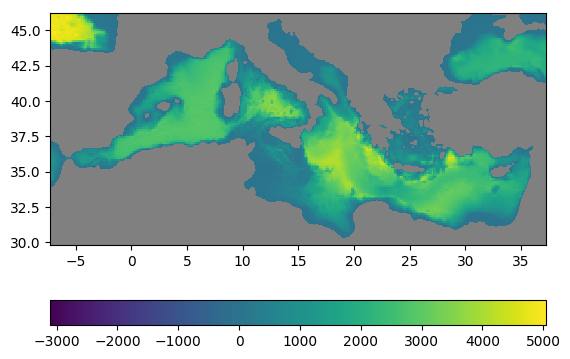

In [68]:
pcolor(bx,by,permutedims(b, [2,1]));
colorbar(orientation = "horizontal");
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspect_ratio)


Plotting gotchas:
* `colorbar()` refers to the last added item. If the last added item is the land-sea mask, the colorbar will be all gray.
* maps look nicer if you set the corresponding aspect ratio based on the average latitude `mean(latr)`.

## Data plotting
The bathymetry is used to display a land-sea mask using the `contourf` function with 2 levels.      
The data are shown as colored circles using `scatter`.

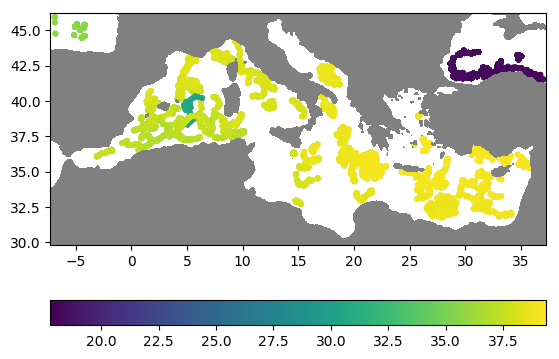

In [69]:
scatter(lonsel,latsel,10,valsel); 
colorbar(orientation = "horizontal");
#clim(36,37.7)
contourf(bx,by,permutedims(b, [2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])

# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspect_ratio)


# Check for duplicates

There are two ways to call the function `checkduplicates`:

In [70]:
?DIVAnd.Quadtrees.checkduplicates

```
dupl = checkduplicates(x,value,delta,deltavalue)
```

Based the coordinates `x` (a tuple of longitude `lons`, latitudes `lats`, depth (`zs`) and time (`times` vector of `DateTime`)) check of points who are in the same spatio-temporal bounding  box of a length `delta`. `delta` is a vector with 4 elements corresponding to longitude, latitude, depth and time (in days). `dupl` a vector of vectors containing indices of the duplicates.

---

```
dupl = checkduplicates(x1,value1,x2,v2,value2,delta,deltavalue)
```

Report duplicate of observation in data set (x2,v2) which are also in data set (x1,v1). `x1` and `x2` is a tuple of vectors with the cooridantes and `v1` and `v2` the corresponding values.


We load a small ODV file containing data in the same domain to test the duplicate detection.     
We use the function `ODVspreadsheet.load` available within `DIVAnd.jl`.

In [71]:
download("https://dox.ulg.ac.be/index.php/s/5FdKh6Md0VAjsIU/download","data/small_ODV_sample.txt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8163k  100 8163k    0     0  7129k      0  0:00:01  0:00:01 --:--:-- 7129k


"data/small_ODV_sample.txt"

In [72]:
?ODVspreadsheet.load

```
 obsvalue,obslon,obslat,obsdepth,obstime,obsids = load(T,fnames,datanames;
    qv_flags = [DIVAnd.ODVspreadsheet.GOOD_VALUE,
                DIVAnd.ODVspreadsheet.PROBABLY_GOOD_VALUE],
    nametype = :P01,
    qvlocalname = "QV:SEADATANET")
```

Load all profiles in all file from the array `fnames` corresponding to one of the parameter names `datanames`. If `nametype` is `:P01` (default), the datanames are P01 vocabulary names with the SDN prefix. If nametype is `:localname`, then they are the ODV column header without units. For example if the column header is `Water body salinity [per mille]`, then `datenames` should be `["Water body salinity"]`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively). Only values matching the quality flag `qv_flags` are retained. `qv_flags` is a vector of Strings (based on http://vocab.nerc.ac.uk/collection/L20/current/, e.g. "1" means "good value"). One can also use the constants these constants (prefixed with `DIVAnd.ODVspreadsheet.`):

`qvlocalname` is the column name to denote quality flags. It is assumed that the quality flags follow immediatly the data column.

|                     constant | value |
| ----------------------------:| -----:|
|         `NO_QUALITY_CONTROL` |   "0" |
|                 `GOOD_VALUE` |   "1" |
|        `PROBABLY_GOOD_VALUE` |   "2" |
|         `PROBABLY_BAD_VALUE` |   "3" |
|                  `BAD_VALUE` |   "4" |
|              `CHANGED_VALUE` |   "5" |
|      `VALUE_BELOW_DETECTION` |   "6" |
|            `VALUE_IN_EXCESS` |   "7" |
|         `INTERPOLATED_VALUE` |   "8" |
|              `MISSING_VALUE` |   "9" |
| `VALUE_PHENOMENON_UNCERTAIN` |   "A" |

If the ODV does not contain a semantic header (e.g. for the aggregated ODV files), then local names must be used.

```julia-repl
julia> data,obslon,obslat,obsdepth,obstime,obsids = DIVAnd.ODVspreadsheet.load(Float64,["data_from_med_profiles_non-restricted_v2.txt"],
      ["Water body salinity"]; nametype = :localname );
```

No checks are done if the units are consistent.

---

```
 profiles,lons,lats,depths,times,ids = load(T,dir,P01names)
```

Load all ODV files under the directory `dir` corresponding the one of the parameter names `P01names`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively).

No checks are done if the units are consistent.


In [73]:
obsval_ODV,obslon_ODV,obslat_ODV,obsdepth_ODV,obstime_ODV,obsid_ODV = ODVspreadsheet.load(Float64,["small_ODV_sample.txt"],
                           ["Water body salinity"]; nametype = :localname );

┌ Info: Reading data from file small_ODV_sample.txt
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:81
┌ Info: No. of profiles in the file: 71
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:250


In [74]:
length(obsval_ODV)

28264

In [75]:
checkobs((obslon_ODV,obslat_ODV,obsdepth_ODV,obstime_ODV),obsval_ODV,obsid_ODV)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (1966-02-13T05:00:00, 2016-11-24T10:39:00)
                          minimum and maximum of data: (37.1775, 39.313)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


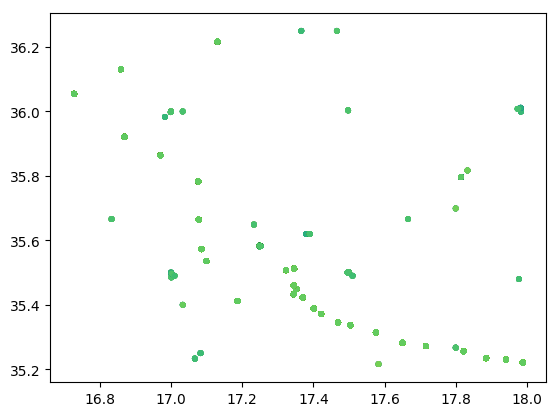

In [76]:
scatter(obslon_ODV,obslat_ODV,10,obsval_ODV); 

Look for duplicates
* within 0.01 degree (about 1km)
* within 0.01 m depth
* within 1 minute.      

Difference in value is 0.01 psu.

In [77]:
dupl = DIVAnd.Quadtrees.checkduplicates((obslon_ODV,obslat_ODV,obsdepth_ODV,obstime_ODV),
    obsval_ODV,(obslon,obslat,obsdepth,obstime),
    obsval,(0.01,0.01,0.01,1/(24*60)),0.01);

In [78]:
size(obsval) == size(dupl)

true

* `dupl` is an array of the same length as `obsval`
* If the i-th element of `dupl` is an empty list, then the i-th element in `obsval` is probably not a duplicate
* Otherwise, the i-th element in `obsval` is probably a duplicate of the element `val_ODV` with the indices `dupl[i]`.

In [79]:
dupl[1]

0-element Array{Int64,1}

To get a list of possible duplicates, we check for the elements of `dupl` that are not empty.

In [80]:
index = findall(.!isempty.(dupl))

5195-element Array{Int64,1}:
 3195059
 3195060
 3195062
 3195063
 3195065
 3195066
 3195067
 3195069
 3195070
 3195071
 3195073
 3195074
 3195075
       ⋮
 4268649
 4268651
 4268652
 4268653
 4268654
 4268656
 4268657
 4268658
 4268660
 4268661
 4268662
 4268663

Number of duplicate candidates

In [81]:
length(index)

5195

Check the first reported duplicate

In [82]:
if length(index) > 0
    index_WOD = index[1]
else
    @info("No duplicate detected")
end

3195059

Show its coordinates and value from the ODV file:

In [83]:
obslon[index_WOD],obslat[index_WOD],obsdepth[index_WOD],obstime[index_WOD],obsval[index_WOD]

(17.885482788085938, 35.23445129394531, 2.4818837642669678, 2016-06-14T10:38:27.239, 38.85300064086914)

They are quite close to the data point with the index:

In [84]:
dupl[index_WOD]

1-element Array{Int64,1}:
 20508

In [85]:
index_ODV = dupl[index_WOD][1]

20508

In [86]:
obslon_ODV[index_ODV],obslat_ODV[index_ODV],
obsdepth_ODV[index_ODV],obstime_ODV[index_ODV],
obsval_ODV[index_ODV]

(17.88548, 35.23445, 2.48189, 2016-06-14T10:39:00, 38.853)

Indeed, it is quite likely that they are duplicates.

Combine the dataset and retain only new points from WOD

In [87]:
#find(isempty.(dupl))

In [88]:
newpoints = findall(isempty.(dupl));
@show length(newpoints)

length(newpoints) = 4504594


4504594

In [89]:
obslon_combined   = [obslon_ODV;   obslon[newpoints]];
obslat_combined   = [obslat_ODV;   obslat[newpoints]];
obsdepth_combined = [obsdepth_ODV; obsdepth[newpoints]];
obstime_combined  = [obstime_ODV;  obstime[newpoints]];
obsval_combined   = [obsval_ODV;   obsval[newpoints]];
obsids_combined   = [obsid_ODV;   obsid[newpoints]];

## CMEMS data download
The function works in a similar way.

In [90]:
?CMEMS.download

```
CMEMS.download(lonr,latr,timerange,param,username,password,basedir[; indexURLs = ...])
```

Download in situ data within the longitude range `lonr` (an array or tuple with two elements: the minimum longitude and the maximum longitude), the latitude range `latr` (likewise), time range `timerange` (an array or tuple with two `DateTime` structures: the starting date and the end date) from the CMEMS (Copernicus Marine environment monitoring service) in situ service [^1]. `param` is one of the parameter codes as defined in [^2] or [^3]. `username` and `password` are the credentials to access data [^1] and `basedir` is the directory under which the data is saved. `indexURLs` is a list of the URL to the `index_history.txt` file. Per default, it includes the URLs of the Baltic, Arctic, North West Shelf, Iberian, Mediteranean and Black Sea Thematic Assembly Center.

As these URLs might change, the latest version of the URLs to the indexes can be obtained at [^1].

# Example

```julia-repl
julia> username = "..."
julia> password = "..."
julia> lonr = [7.6, 12.2]
julia> latr = [42, 44.5]
julia> timerange = [DateTime(2016,5,1),DateTime(2016,8,1)]
julia> param = "TEMP"
julia> basedir = "/tmp"
julia> files = CMEMS.download(lonr,latr,timerange,param,username,password,basedir)
```

[^1]: http://marine.copernicus.eu/

[^2]: http://www.coriolis.eu.org/Documentation/General-Informations-on-Data/Codes-Tables

[^3]: https://doi.org/10.13155/40846


## Exercice
1. Download data from CMEMS in the same domain and for the same time period.
2. Plot the data location on a map along with the WOD observations.
3. Check for the duplicates between the two datasets.